In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets

import pennylane as qml
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import sklearn.decomposition

import keras.metrics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [4]:
data = pd.read_csv('DrDoS_SSDP_features_removed.csv', skiprows=[i for i in range(1,141550)], skipfooter=141547, engine="python")

n_features = 2
x = StandardScaler().fit_transform(np.array(data.drop(columns=['Label'])))
y = np.array(data['Label'].astype('category').cat.codes.astype(int))

np.random.seed(1967)
x, y = zip(*np.random.permutation(list(zip(x, y))))

pca = sklearn.decomposition.PCA(n_components=n_features)
pca.fit(x)
x = pca.transform(x)

minmax_scale = MinMaxScaler((-1, 1)).fit(x)
x = minmax_scale.transform(x)


trainX, testX, trainy, testy = train_test_split(x, y, stratify=y, test_size=0.3, random_state=109)

trainy = tf.one_hot(trainy, depth=2)
testy = tf.one_hot(testy, depth=2)

In [5]:
n_qubits = 2
layers = 1
data_dimension = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]


weight_shapes = {"weights": (layers,n_qubits,3)}

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(n_qubits,activation='relu',input_dim=2))
model.add(qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
model.add(tf.keras.layers.Dense(data_dimension, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"])

In [6]:
%load_ext memory_profiler

In [7]:
%%time

history = model.fit(trainX, trainy, validation_data=(trainX, trainy), epochs=30, batch_size=5)

Epoch 1/30
413/413 [==============================] - 146s 352ms/step - loss: 0.4131 - accuracy: 0.8349 - val_loss: 0.0577 - val_accuracy: 0.9995
Epoch 2/30
413/413 [==============================] - 156s 377ms/step - loss: 0.0238 - accuracy: 0.9995 - val_loss: 0.0121 - val_accuracy: 0.9995
Epoch 3/30
413/413 [==============================] - 144s 348ms/step - loss: 0.0097 - accuracy: 0.9995 - val_loss: 0.0078 - val_accuracy: 0.9995
Epoch 4/30
413/413 [==============================] - 145s 351ms/step - loss: 0.0073 - accuracy: 0.9995 - val_loss: 0.0064 - val_accuracy: 0.9995
Epoch 5/30
413/413 [==============================] - 143s 347ms/step - loss: 0.0063 - accuracy: 0.9995 - val_loss: 0.0057 - val_accuracy: 0.9995
Epoch 6/30
413/413 [==============================] - 143s 347ms/step - loss: 0.0057 - accuracy: 0.9995 - val_loss: 0.0051 - val_accuracy: 0.9995
Epoch 7/30
413/413 [==============================] - 127s 309ms/step - loss: 0.0053 - accuracy: 0.9995 - val_loss: 0.0048 -

Plot Training and Validation loss

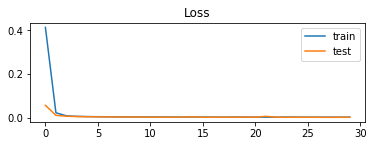

In [8]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


Plot Training and Validation Accuracy

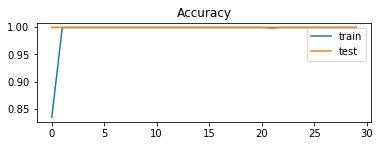

In [9]:
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()

Predict using test data

In [10]:
predy = model.predict(testX)
predy

array([[2.4881068e-05, 9.9997509e-01],
       [3.2592427e-05, 9.9996746e-01],
       [9.9999022e-01, 9.7645880e-06],
       ...,
       [6.0318478e-05, 9.9993968e-01],
       [1.1297456e-04, 9.9988699e-01],
       [2.3335928e-05, 9.9997663e-01]], dtype=float32)

Convert hot encoded labels back to original labels

In [11]:
from sklearn.metrics import multilabel_confusion_matrix

rounded_labels_pred=np.argmax(predy, axis=1)

rounded_labels_real=np.argmax(testy, axis=1)

rounded_labels_real_train=np.argmax(trainy, axis=1)

In [12]:
rounded_labels_real

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,

In [13]:
rounded_labels_pred

array([1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,

Dispaly Confusion Matrix

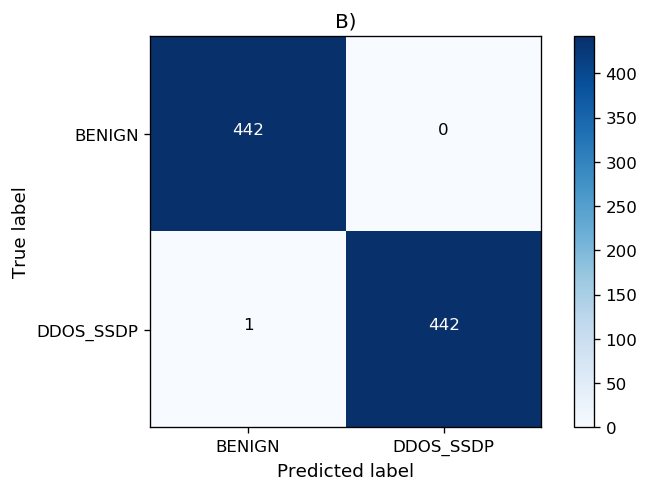

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(rounded_labels_real, rounded_labels_pred)

import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    fig = plt.figure(figsize=(6, 4), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', fontsize=11)
    plt.xlabel('Predicted label', fontsize=11)
    plt.show()
    return fig
fig = plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = ['BENIGN', 'DDOS_SSDP'],
                      title        = "B)")
fig.savefig('CONFUSQNN.pdf')

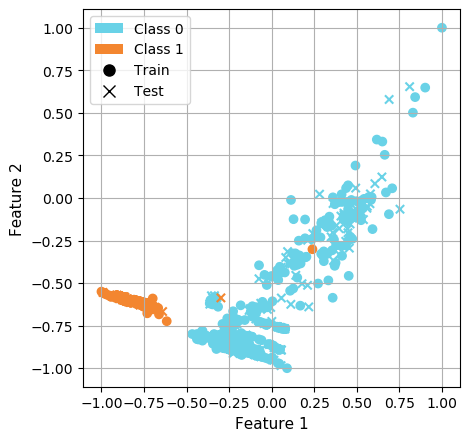

In [15]:
colours = ["#69D2E7", "#F38630"]


def plot_points(x_train, y_train, x_test, y_test):
    c_train = []
    c_test = []

    for y in y_train:
        c_train.append(colours[y])

    for y in y_test:
        c_test.append(colours[y])
    fig = plt.figure(figsize=(5,5), dpi=100)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=c_train)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=c_test, marker="x")

    plt.xlabel("Feature 1", fontsize=11)
    plt.ylabel("Feature 2", fontsize=11)
    plt.grid()
    ax = plt.gca()
    ax.set_aspect(1)

    c_transparent = "#00000000"

    custom_lines = [
        Patch(facecolor=colours[0], edgecolor=c_transparent, label="Class 0"),
        Patch(facecolor=colours[1], edgecolor=c_transparent, label="Class 1"),
        #Patch(facecolor=colours[2], edgecolor=c_transparent, label="Class 2"),
        Line2D([0], [0], marker="o", color=c_transparent, label="Train",
               markerfacecolor="black", markersize=8),
        Line2D([0], [0], marker="x", color=c_transparent, label="Test",
               markerfacecolor="black", markersize=8),
    ]

    ax.legend(handles=custom_lines)
    return fig

fig = plot_points(trainX, rounded_labels_real_train, testX, rounded_labels_real)
fig.savefig('DATA.pdf')

In [16]:
colours_prediction = {"correct": "#00A0B0", "incorrect": "#CC333F"}
markers = ["o", "v"]


def plot_points_prediction(x, y, p):
    c = {0: [], 1: [], 2: []}
    x_ = {0: [], 1: [], 2: []}

    for i in range(885):
        x_[y[i]].append(x[i])
        if p[i] == y[i]:
            c[y[i]].append(colours_prediction["correct"])
        else:
            c[y[i]].append(colours_prediction["incorrect"])
    fig = plt.figure(figsize=(5,5), dpi=100) 
    for i in range(2):
        x_class = np.array(x_[i])
        plt.scatter(x_class[:, 0], x_class[:, 1], c=c[i], marker=markers[i])
        
    plt.xlabel("Feature 1", fontsize=11)
    plt.ylabel("Feature 2", fontsize=11)
    plt.title("A)")
    plt.grid()
    
    ax = plt.gca()
    ax.set_aspect(1)
    c_transparent = "#00000000"

    custom_lines = [
        Patch(
            facecolor=colours_prediction["correct"],
            edgecolor=c_transparent, label="Correct"
        ),
        Patch(
            facecolor=colours_prediction["incorrect"],
            edgecolor=c_transparent, label="Incorrect"
        ),
        Line2D([0], [0], marker=markers[0], color=c_transparent, label="Benign",
               markerfacecolor="black", markersize=10),
        Line2D([0], [0], marker=markers[1], color=c_transparent, label="DDoS",
               markerfacecolor="black", markersize=10),
    ]

    ax.legend(handles=custom_lines)
    return fig

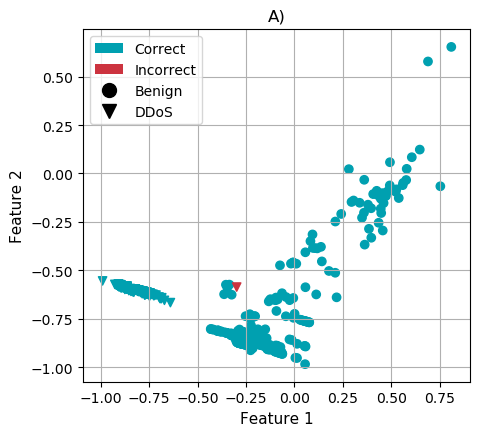

In [17]:
fig = plot_points_prediction(testX, rounded_labels_real, rounded_labels_pred)
fig.savefig('PREDICQNN.pdf')

In [18]:
from sklearn.metrics import classification_report, recall_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, make_scorer

#Metrics
classification = classification_report(rounded_labels_real, rounded_labels_pred)
confusion = confusion_matrix(rounded_labels_real, rounded_labels_pred)
    
    # Accuracy
accuracy = round(accuracy_score(rounded_labels_real, rounded_labels_pred)*100,5)
    
    # Recall
recall = round(recall_score(rounded_labels_real, rounded_labels_pred, average='macro')*100,5)
    
    # Precision
precision = round(precision_score(rounded_labels_real, rounded_labels_pred, average='weighted')*100,5)
    
    # F1
f1 = round(f1_score(rounded_labels_real, rounded_labels_pred, average='weighted')*100,5)
    

In [19]:
print(accuracy)
print(recall)
print(precision)
print(f1)
print(1-(accuracy/100))

99.88701
99.88713
99.88726
99.88701
0.001129900000000017
CPU times: user 43min 50s, sys: 11.8 s, total: 44min 2s 
 Wall time: 43min 45s


In [20]:
print(qnode.draw())

 0: ──RX(0.067)──Rot(-0.071, -0.033, 0.591)──╭C──╭X──┤ ⟨Z⟩ 
 1: ──RX(1.317)──Rot(1.571, -1.375, 0.309)───╰X──╰C──┤ ⟨Z⟩ 

